In [11]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

sample_sentences = [
    "The quick brown fox jumps over the lazy dog near the riverbank.",
    "She packed her bags and moved to a small cottage in the mountains.",
    "He always brings a cup of hot coffee before starting his morning work.",
    "They traveled across Europe by train, enjoying the scenic countryside views.",
    "We should focus on our long-term goals rather than temporary distractions.",
    "Despite the stormy weather, the hikers reached the summit before sunset.",
    "The scientist carefully recorded every observation in her laboratory notebook.",
    "Reading a good book before bed helps me sleep better at night.",
    "I met an old friend unexpectedly during my trip to New York City.",
    "The museum had an impressive collection of rare and ancient artifacts.",
    "Learning a new language opens up many opportunities for travel and career.",
    "He apologized sincerely for the mistake and promised to improve next time.",
    "The children spent the afternoon building sandcastles on the sunny beach.",
    "Technology continues to change how we communicate and interact with others.",
    "After weeks of training, she finally completed the marathon successfully.",
    "They renovated the old house and transformed it into a beautiful home.",
    "The teacher explained the difficult concept with clear and simple examples.",
    "We were amazed by the stunning colors of the sunset over the ocean.",
    "He played the piano beautifully, impressing everyone at the concert hall.",
    "Cooking with fresh ingredients makes every meal more delicious and healthy."
]
tokenized_sentences = [word_tokenize(sent.lower()) for sent in sample_sentences]
tokens = [token for sent in tokenized_sentences for token in sent]

print(f"Number of tokens: {len(tokens)}")

Number of tokens: 255


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [12]:
from collections import Counter

vocab_size = 10000
special_tokens = ["<unk>", "<pad>"]
freq = Counter(tokens).most_common(vocab_size - len(special_tokens))
vocab = special_tokens + [w.lower() for w, _ in freq]

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

# Encode corpus
encoded = [word2idx.get(w.lower(), word2idx["<unk>"]) for w in tokens]

In [13]:
from collections import Counter
vocab_size = 10000
special_tokens = ["<unk>", "<pad>"]
freq = Counter(tokens).most_common(vocab_size - len(special_tokens))

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class SampleDataset(Dataset):
    def __init__(self, data, context_size):
        self.data = data
        self.context_size = context_size

    def __len__(self):
        return len(self.data) - self.context_size

    def __getitem__(self, idx):
        context = self.data[idx: idx + self.context_size - 1]
        target = self.data[idx + self.context_size - 1]
        return torch.tensor(context), torch.tensor(target)


# Split into train/val
split_idx = int(len(encoded) * 0.8)
train_data = encoded[:split_idx]
val_data = encoded[split_idx:]

context_size = 5
train_loader = DataLoader(SampleDataset(train_data, context_size), batch_size=128, shuffle=True)
val_loader = DataLoader(SampleDataset(val_data, context_size), batch_size=128)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BengioNeuralLM(nn.Module):
    def __init__(self, vocab_size, embed_size, context_size, hidden_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_size = context_size
        self.embed_size = embed_size

        # Word embeddings C(i) ∈ ℝ^m
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Hidden layer: H ∈ ℝ^{h × (n−1)m}, d ∈ ℝ^h
        self.H = nn.Linear((context_size - 1) * embed_size, hidden_size)

        # Output weights: U ∈ ℝ^{|V| × h}, W ∈ ℝ^{|V| × (n−1)m}, b ∈ ℝ^{|V|}
        self.U = nn.Linear(hidden_size, vocab_size, bias=False)
        self.W = nn.Linear((context_size - 1) * embed_size, vocab_size, bias=False)
        self.b = nn.Parameter(torch.zeros(vocab_size))

    def forward(self, x):
        """
        x: tensor of shape (batch_size, context_size - 1)
        """
        # Step 1: get word embeddings for each word in context
        embedded = self.embed(x)  # (batch_size, context_size-1, embed_size)

        # Step 2: flatten the embeddings
        x_flat = embedded.view(embedded.size(0), -1)  # (batch_size, (n-1)*m)

        # Step 3: hidden activation: tanh(d + Hx)
        h = torch.tanh(self.H(x_flat))  # (batch_size, h)

        # Step 4: compute logits: y = b + Wx + Uh
        logits = self.b + self.W(x_flat) + self.U(h)  # (batch_size, |V|)

        # Step 5: log-probabilities over vocabulary
        return F.log_softmax(logits, dim=1)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BengioNeuralLM(
    vocab_size=10000,       # V = 10,000
    embed_size=30,          # m = 30
    context_size=5,         # n = 5
    hidden_size=100         # h = 100
).to(device)

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)
criterion = nn.NLLLoss()

In [18]:
num_epoch = 100
train_losses = []
val_ppls = []

for epoch in range(num_epoch):
    model.train()
    total_loss = 0

    for step, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        log_probs = model(x)
        loss = criterion(log_probs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #if step % 100 == 0:
        #    print(f"Epoch {epoch+1} | Step {step} | Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / len(train_loader)

    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} done. Train Loss: {avg_train_loss:.4f}")

Epoch 1 done. Train Loss: 9.4331
Epoch 2 done. Train Loss: 9.2807
Epoch 3 done. Train Loss: 9.1097
Epoch 4 done. Train Loss: 8.9652
Epoch 5 done. Train Loss: 8.7998
Epoch 6 done. Train Loss: 8.6034
Epoch 7 done. Train Loss: 8.4391
Epoch 8 done. Train Loss: 8.2716
Epoch 9 done. Train Loss: 8.0699
Epoch 10 done. Train Loss: 7.8986
Epoch 11 done. Train Loss: 7.7728
Epoch 12 done. Train Loss: 7.5915
Epoch 13 done. Train Loss: 7.4025
Epoch 14 done. Train Loss: 7.2344
Epoch 15 done. Train Loss: 7.0794
Epoch 16 done. Train Loss: 6.8799
Epoch 17 done. Train Loss: 6.7335
Epoch 18 done. Train Loss: 6.5529
Epoch 19 done. Train Loss: 6.2880
Epoch 20 done. Train Loss: 6.1394
Epoch 21 done. Train Loss: 5.9873
Epoch 22 done. Train Loss: 5.8197
Epoch 23 done. Train Loss: 5.6484
Epoch 24 done. Train Loss: 5.4306
Epoch 25 done. Train Loss: 5.2373
Epoch 26 done. Train Loss: 5.1105
Epoch 27 done. Train Loss: 4.8934
Epoch 28 done. Train Loss: 4.7119
Epoch 29 done. Train Loss: 4.4605
Epoch 30 done. Train Lo

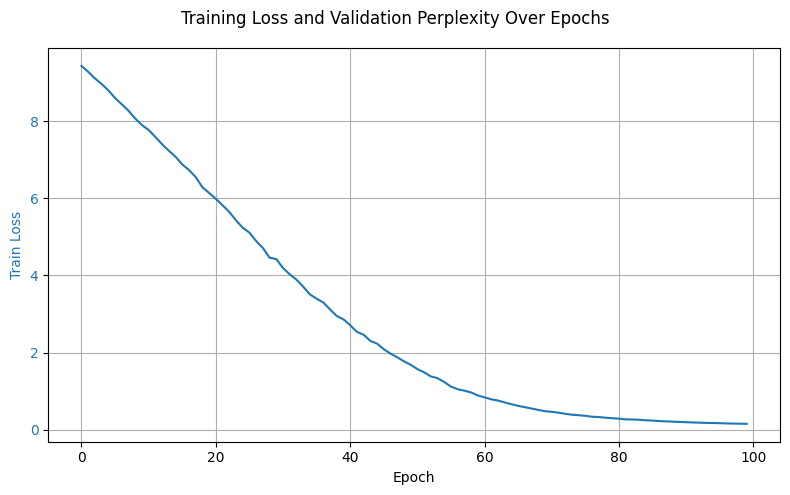

In [19]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 5))

# Training Loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:blue')
ax1.plot(train_losses, label='Train Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Show
fig.suptitle('Training Loss and Validation Perplexity Over Epochs')
fig.tight_layout()
plt.show()

In [21]:
def predict_next(model, context_words, topk=5):
    model.eval()
    context_ids = [word2idx.get(w, word2idx['<unk>']) for w in context_words]
    context_tensor = torch.tensor([context_ids], device=device)
    with torch.no_grad():
        log_probs = model(context_tensor)
        topk_probs, topk_ids = torch.topk(log_probs, topk)
        return [idx2word.get(i.item(), '<unk>') for i in topk_ids[0]]

# Example
print(predict_next(model, "the hikers reached the".split()))

['summit', 'afternoon', 'impressive', 'always', 'the']
